In [3]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math

In [4]:
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn, rnn
import mxnet as mx
import datetime
import seaborn as sns

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

# Introduction 

## Reference

In this notebook, we run through the data collection process, and the decision making for the feature preparation. We based off our study on the use of QLSTM on three projects, two of which described their data collection process:

Stock price prediction using BERT and GAN: https://arxiv.org/pdf/2107.09055.pdf  <br>
Using GANs to predict stock price movement: https://towardsdatascience.com/aifortrading-2edd6fac689d <br>

We leverage their some of their ideas, and repurpose part of their code for our purpose.

<b> Note that the relevant csv file for sentiment analysis is not present in the GitHub. This is because the file size is exceeds the size for GitHub upload. To test this part, please refer to the site (attached in the sentiment analysis portion below) to download it. </b>

## Brief Outline

For our study, we are interested in predicting the movement of the stock prices of Merck & Co. Inc, with call symbol MRK in the stock market. In order to get the historical data of MRK, we use Yahoo Finance, both downloading the historical data from their website as well as making use of the yfinance Python package. <br>

In order to forecast the stock price of MRK, we need to collect data that would be useful in telling us whether the stock price might move up or down. These data give us key information that highlights different aspects of the stock. We use the following:

- Technical indicators
- Trend approximations (Fourier Transforms)
- ARIMA 
- Correlated assets
- Sentimental analysis


# Data Collection

## Stock price data of MRK

We collect the historical stock prices data for MRK using Yahoo Finance, and we choose to predict the Closing prices of the stock each day. The following tables and figures demonstrate key information about the stock.

In [6]:
dataset_ex_df = pd.read_csv('MRK.csv', header=0, parse_dates=[0], date_parser=helper.date_parser)

In [7]:
dataset_ex_df[['Date', 'Close']].head()

,Date,Close
0,2009-07-27,29.360687
1,2009-07-28,28.645039
2,2009-07-29,28.501907
3,2009-07-30,28.568703
4,2009-07-31,28.635496


In [8]:
print('There are {} number of days in the dataset.'.format(dataset_ex_df.shape[0]))

There are 2738 number of days in the dataset.


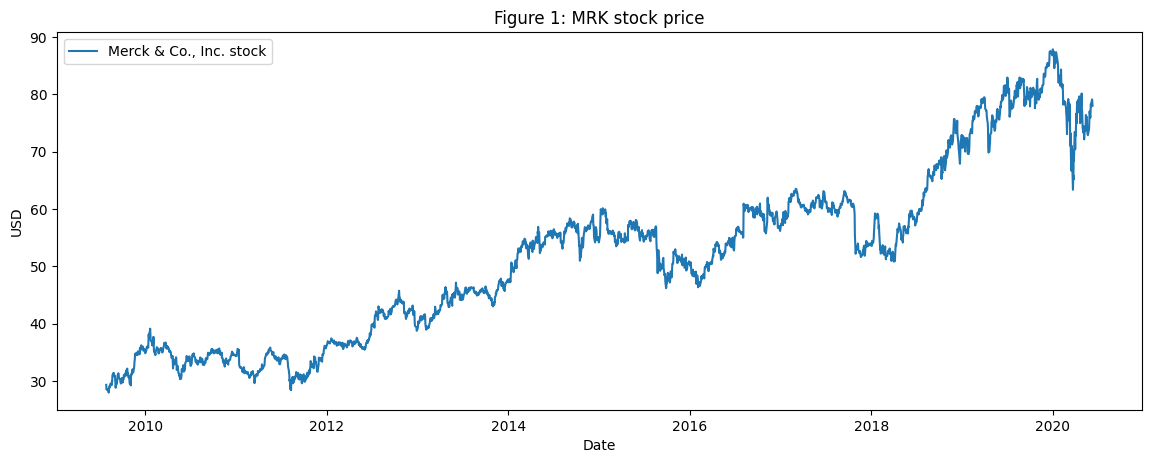

In [9]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(dataset_ex_df['Date'], dataset_ex_df['Close'], label='Merck & Co., Inc. stock')
#plt.vlines(datetime.date(2017,3, 7), 20, 90, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD')
plt.title('MRK stock price')
plt.legend()
plt.show()

## Technical Indicators

Many investors use technical indicators of a stock to decide whether to invest or not. Thus, we use various technical indicators as independent variables for our model. The list includes:

- Moving averages (7 day and 21 day)
- Moving averages convergence divergences (MACD)
- Bollinger bands
- Exponential moving average 
- Momentum

The following code gets the technical indicators and plots their information

In [10]:
dataset_TI_df = helper.get_technical_indicators(dataset_ex_df, "Close")
dataset_TI_df = dataset_TI_df[20:]
dataset_TI_df.reset_index(drop=True, inplace=True)
dataset_TI_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,2009-08-24,31.479008,31.488550,30.830153,31.011450,20.021574,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,27.528586,30.897808,30.011450,3.401579
1,2009-08-25,31.402672,31.536261,31.011450,31.440840,20.298801,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,27.372247,31.259829,30.440840,3.415785
2,2009-08-26,31.316793,31.469465,30.982824,31.183207,20.132467,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,27.367319,31.208748,30.183207,3.407286
3,2009-08-27,31.106871,31.488550,30.734734,31.364504,20.249514,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,27.383684,31.312585,30.364504,3.413274
4,2009-08-28,31.412214,31.412214,30.648855,30.839695,19.910694,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,27.475534,30.997325,29.839695,3.395840


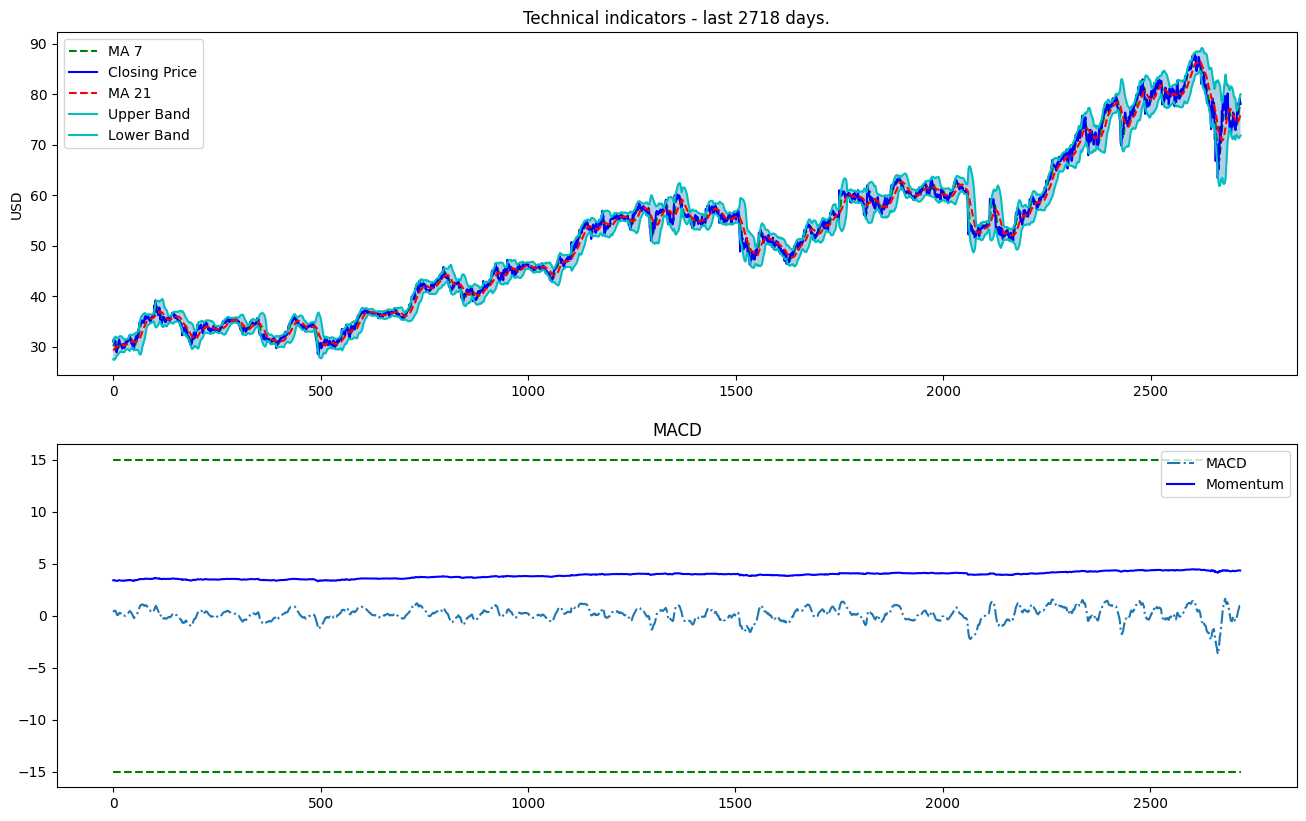

In [11]:
helper.plot_technical_indicators(dataset_TI_df, len(dataset_TI_df))

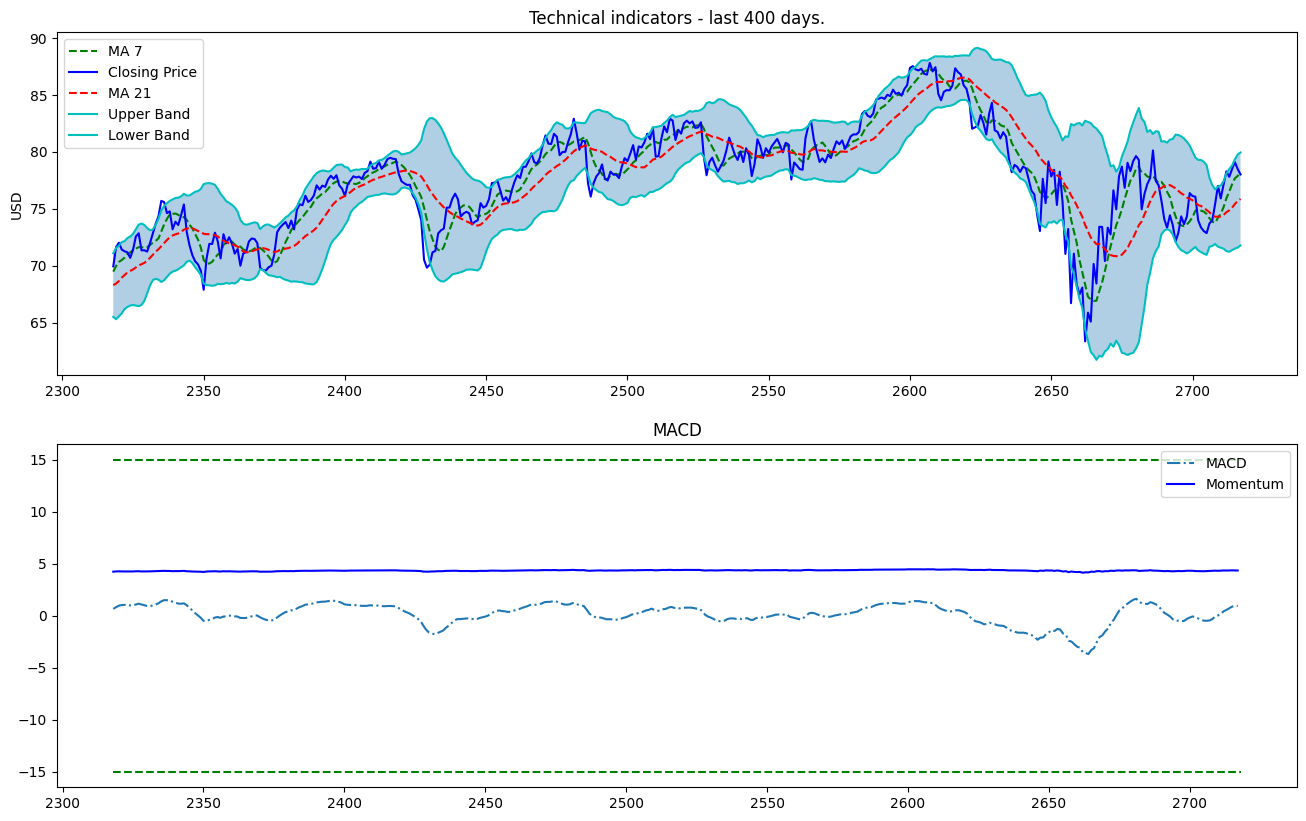

In [12]:
helper.plot_technical_indicators(dataset_TI_df, 400)

## Trend Approximations (Fourier Transforms)

Performing Fourier transforms of the stock prices allow to get trend approximations of the stock by reducing the noise and a lot of the random walk, thus getting a general idea of long term and short term trends of the stock. <br>

The following code performs the Fourier transforms with 3, 6 and 9 components, and plots the data.

In [14]:
data_FT = dataset_ex_df[['Date', 'Close']]

In [15]:
close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
fft_df = pd.DataFrame({'fft':close_fft})
fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

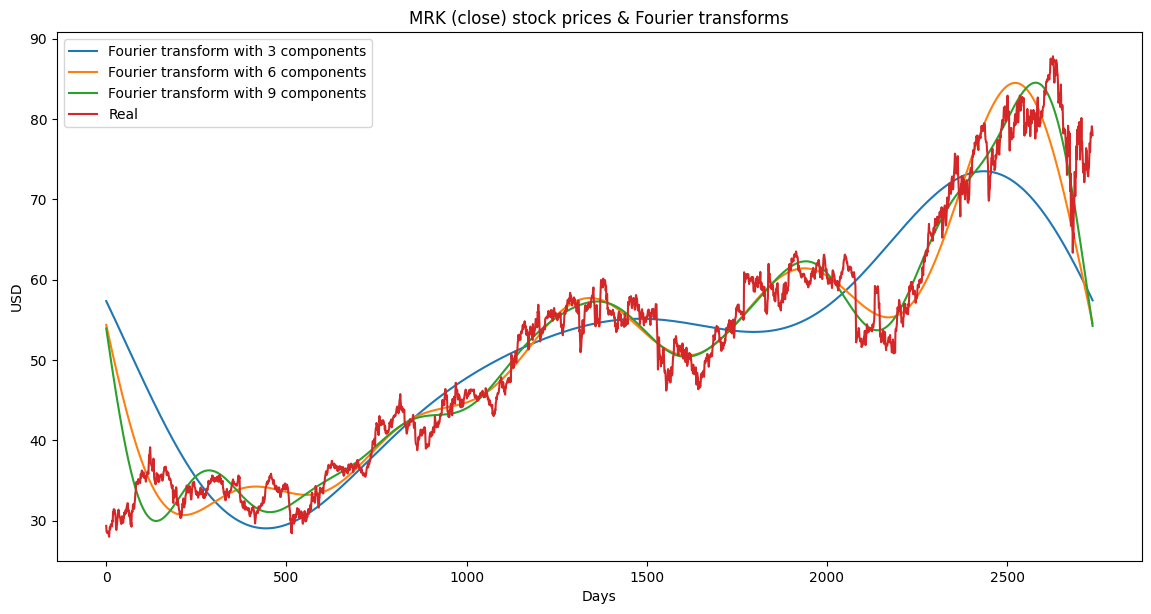

In [16]:
plt.figure(figsize=(14, 7), dpi=100)
fft_list = np.asarray(fft_df['fft'].tolist())
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
plt.plot(data_FT['Close'],  label='Real')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('MRK (close) stock prices & Fourier transforms')
plt.legend()
plt.show()

## ARIMA

Prior to neural networks and even today, many companies use ARIMA as a model to predict time series data. Hence, we use it as an independent variable, as it might contain patterns essential to the prediction.

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data_FT['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit()
#model_fit = model.fit(disp=0)
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2738
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -2985.587
Date:                Thu, 24 Feb 2022   AIC                           5983.174
Time:                        15:25:50   BIC                           6018.662
Sample:                             0   HQIC                          5995.999
                               - 2738                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1034      0.012     -8.991      0.000      -0.126      -0.081
ar.L2          0.0311      0.010      3.104      0.002       0.011       0.051
ar.L3         -0.0121      0.011     -1.103      0.2

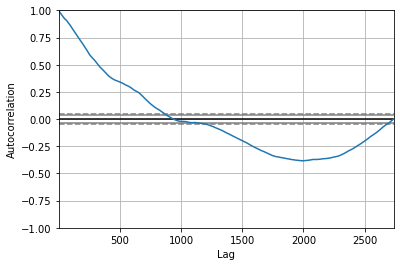

<Figure size 800x560 with 0 Axes>

In [19]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show() 

In [20]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    #model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

In [32]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 0.957


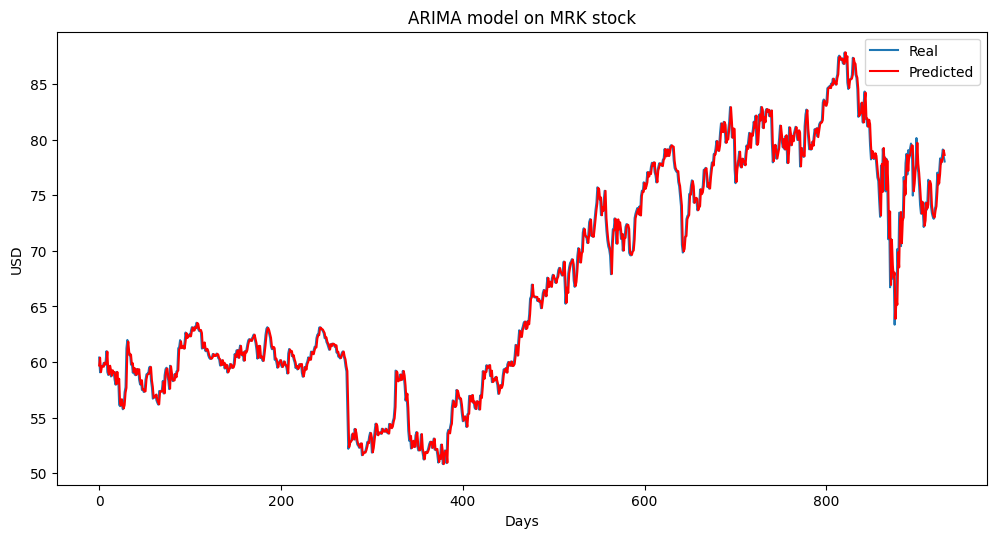

In [30]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('ARIMA model on MRK stock')
plt.legend()
plt.show()

## Correlated assets

The information about the company MRK is useful to understand the activity of the entire market in general. Thus, we collect correlated assets of MRK as well. To decide on the correlated assets, we researched the following sites:

https://www.tipranks.com/stocks/mrk/similar-stocks <br>
https://seekingalpha.com/symbol/MRK/peers/related-stocks <br>
https://marketchameleon.com/Overview/MRK/Similar/ <br>

We then collected the data of the assets that MRK is related to, as well as information on the indexes of MRK. To do so, we collect the info using the yfinance package, i.e the data from Yahoo Finance.

In [35]:
import yfinance as yf

1. SNP 500

In [36]:
SNP = yf.Ticker("^GSPC")

In [37]:
SNP_data = SNP.history(start="2009-07-27", end="2020-06-11")
SNP_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,978.630005,982.489990,972.289978,982.179993,4631290000,0,0
2009-07-28,981.479980,982.349976,969.349976,979.619995,5490350000,0,0
2009-07-29,977.659973,977.760010,968.650024,975.150024,5178770000,0,0
2009-07-30,976.010010,996.679993,976.010010,986.750000,6035180000,0,0
2009-07-31,986.799988,993.179993,982.849976,987.479980,5139070000,0,0
...,...,...,...,...,...,...,...
2020-06-04,3111.560059,3128.909912,3090.409912,3112.350098,6428130000,0,0
2020-06-05,3163.840088,3211.719971,3163.840088,3193.929932,8617590000,0,0
2020-06-08,3199.919922,3233.129883,3196.000000,3232.389893,8437380000,0,0


2. Pfizer

In [38]:
PFE = yf.Ticker("PFE")

In [39]:
PFE_data = PFE.history(start="2009-07-27", end="2020-06-11")
PFE_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,9.705484,9.835442,9.581433,9.817720,50004184,0.0,0
2009-07-28,9.740927,9.841349,9.427847,9.469197,79445882,0.0,0
2009-07-29,9.451475,9.498733,9.238817,9.303796,64191867,0.0,0
2009-07-30,9.427849,9.605064,9.386499,9.416035,51094020,0.0,0
2009-07-31,9.516456,9.557806,9.392406,9.410127,45270143,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,31.719286,32.234470,31.710404,31.985760,27013388,0.0,0
2020-06-05,32.190055,32.412119,31.870286,31.967995,36705655,0.0,0
2020-06-08,31.799234,32.509832,31.692646,32.500950,30194149,0.0,0


3. Johnson and Johnson

In [40]:
JNJ = yf.Ticker("JNJ")

In [41]:
JNJ_data = JNJ.history(start="2009-07-27", end="2020-06-11")
JNJ_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,42.245872,42.383277,41.648148,42.094723,7937700,0.0,0
2009-07-28,41.929822,42.300823,41.634397,41.854248,9025500,0.0,0
2009-07-29,41.730584,42.211508,41.696230,42.019138,10522700,0.0,0
2009-07-30,42.362661,42.919162,42.266477,42.451977,12636500,0.0,0
2009-07-31,42.479453,42.713043,41.758063,41.833637,13230900,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,140.361966,141.863105,139.195469,140.295029,8170500,0.0,0
2020-06-05,141.212953,143.077432,140.170759,140.840057,9725400,0.0,0
2020-06-08,139.482330,141.136455,139.348470,140.333298,7555600,0.0,0


4. Bristol-Myers Squibb Company

In [42]:
BMY = yf.Ticker("BMY")

In [43]:
BMY_data = BMY.history(start="2009-07-27", end="2020-06-11")
BMY_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,14.151243,14.184229,13.867558,14.105061,12992300,0.0,0
2009-07-28,14.032486,14.184224,13.841163,13.973110,11360400,0.0,0
2009-07-29,13.900538,14.269988,13.900538,14.243599,13095000,0.0,0
2009-07-30,14.408534,14.494298,14.217211,14.223808,11853800,0.0,0
2009-07-31,14.237003,14.408533,14.032487,14.342560,17007400,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,56.618244,57.820270,56.618244,57.630974,13476900,0.0,0
2020-06-05,57.905451,58.463873,57.290240,58.047424,11862600,0.0,0
2020-06-08,57.356493,58.142071,57.167201,58.142071,12549100,0.0,0


5. Viatris Inc

In [44]:
VTRS = yf.Ticker("VTRS")

In [45]:
VTRS_data = VTRS.history(start="2009-07-27", end="2020-06-11")
VTRS_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,12.782050,12.801595,11.394396,11.824374,50917600,0,0
2009-07-28,12.029592,13.065446,11.697337,12.273897,46254500,0,0
2009-07-29,12.381391,12.703874,12.127313,12.615924,13872800,0,0
2009-07-30,12.997040,13.241346,12.615924,12.830913,18346600,0,0
2009-07-31,12.860228,13.133850,12.830912,12.889544,8805200,0,0
...,...,...,...,...,...,...,...
2020-06-04,16.925469,17.296814,16.866836,17.296814,4732300,0,0
2020-06-05,17.736562,18.293577,17.140458,17.267496,7859900,0,0
2020-06-08,17.589980,18.801734,17.482485,18.352213,10387700,0,0


6. Amgen Inc

In [46]:
AMGN = yf.Ticker("AMGN")

In [47]:
AMGN_data = AMGN.history(start="2009-07-27", end="2020-06-11")
AMGN_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,46.776827,47.152515,45.833777,46.592819,10946800,0.0,0
2009-07-28,48.080229,48.179902,47.091176,47.857883,18802100,0.0,0
2009-07-29,48.011220,48.685924,47.811878,48.478912,11811900,0.0,0
2009-07-30,48.816264,49.452632,48.294905,48.386909,9855700,0.0,0
2009-07-31,48.333252,48.770275,47.535875,47.773556,6361100,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,209.488745,212.031791,208.008462,209.593124,2392800,0.0,0
2020-06-05,208.473415,214.404042,207.050064,214.138351,3714600,0.0,0
2020-06-08,211.860980,214.688699,210.418647,214.214249,2270500,0.0,0


7. Verizon Comms

In [48]:
VZ = yf.Ticker("VZ")

In [49]:
VZ_data = VZ.history(start="2009-07-27", end="2020-06-11")
VZ_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,16.235546,16.375597,15.830954,16.079933,20398043,0.0,0.0
2009-07-28,16.017684,16.297786,15.955440,16.287413,17952338,0.0,0.0
2009-07-29,16.214797,16.603828,16.126617,16.588266,22084490,0.0,0.0
2009-07-30,16.681635,16.956550,16.645325,16.759441,20638583,0.0,0.0
2009-07-31,16.723129,16.774999,16.515647,16.634949,27609451,0.0,0.0
...,...,...,...,...,...,...,...
2020-06-04,52.479259,53.061948,52.266527,52.923214,16147300,0.0,0.0
2020-06-05,53.413411,53.755626,52.793725,53.404163,17105600,0.0,0.0
2020-06-08,53.320928,53.829627,52.969462,53.727886,14963000,0.0,0.0


8. Sanofi - American Depositary Shares

In [50]:
SNY = yf.Ticker("SNY")

In [51]:
SNY_data = SNY.history(start="2009-07-27", end="2020-06-11")
SNY_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,20.203553,20.264961,20.019325,20.185129,1018800,0.0,0
2009-07-28,20.559722,20.694823,20.332510,20.535158,1306000,0.0,0
2009-07-29,20.443048,20.547442,20.111439,20.258821,2222600,0.0,0
2009-07-30,20.093016,20.406201,20.050030,20.172846,1707600,0.0,0
2009-07-31,20.099156,20.203553,19.865802,20.043888,1355800,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,47.862264,48.575334,47.688819,48.132076,2586700,0.0,0
2020-06-05,48.478975,48.565700,48.132077,48.276615,1077900,0.0,0
2020-06-08,48.315160,48.980050,48.045352,48.960777,1644100,0.0,0


9. Glaxosmithkline PLC

In [52]:
GSK = yf.Ticker("GSK")

In [53]:
GSK_data = GSK.history(start="2009-07-27", end="2020-06-11")
GSK_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,19.711151,19.808452,19.537033,19.793089,1568300,0.000,0
2009-07-28,19.752123,19.915998,19.649700,19.813576,1105500,0.000,0
2009-07-29,19.943659,20.005852,19.767441,19.897013,1666700,0.461,0
2009-07-30,20.036951,20.213169,19.917746,19.917746,1047200,0.000,0
2009-07-31,19.897022,19.995497,19.694890,19.845194,1079200,0.000,0
...,...,...,...,...,...,...,...
2020-06-04,38.506410,38.866196,38.377252,38.423382,2802300,0.000,0
2020-06-05,38.497180,38.810840,38.395701,38.469505,2779000,0.000,0
2020-06-08,38.746266,39.087601,38.534084,39.087601,5348700,0.000,0


10. Eli Lilly And Company

In [54]:
LLY = yf.Ticker("LLY")

In [55]:
LLY_data = LLY.history(start="2009-07-27", end="2020-06-11")
LLY_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,22.935995,23.153368,22.731797,23.153368,4740800,0.0,0
2009-07-28,23.061147,23.265345,22.738384,23.100670,4896400,0.0,0
2009-07-29,23.047973,23.232408,22.797665,22.988689,4125500,0.0,0
2009-07-30,23.199471,23.482713,22.995272,23.087490,4579700,0.0,0
2009-07-31,23.061149,23.324630,22.975519,22.982105,5893600,0.0,0
...,...,...,...,...,...,...,...
2020-06-04,147.830390,149.122108,145.402324,146.373550,3328700,0.0,0
2020-06-05,145.392609,147.393333,144.071740,144.916718,4578800,0.0,0
2020-06-08,142.527494,144.955560,142.304116,144.916718,4076400,0.0,0


11. Novartis Ag

In [56]:
NVS = yf.Ticker("NVS")

In [57]:
NVS_data = NVS.history(start="2009-07-27", end="2020-06-11")
NVS_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,25.491292,25.566523,25.236669,25.531801,809323,0.0,0.0
2009-07-28,25.473926,25.601240,25.282961,25.589666,759773,0.0,0.0
2009-07-29,25.398701,25.468145,25.109356,25.248241,1394888,0.0,0.0
2009-07-30,25.572308,25.919523,25.421849,25.815357,1414976,0.0,0.0
2009-07-31,26.012110,26.538717,25.965814,26.399832,1835150,0.0,0.0
...,...,...,...,...,...,...,...
2020-06-04,82.201473,83.009063,81.663080,81.836136,1801100,0.0,0.0
2020-06-05,82.364910,83.114817,82.201470,82.576424,1533300,0.0,0.0
2020-06-08,82.432213,82.884082,81.893820,82.364914,1956200,0.0,0.0


12. NYSE

In [58]:
NYSE = yf.Ticker("^NYA")

In [59]:
NYSE_data = NYSE.history(start="2009-07-27", end="2020-06-11")
NYSE_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,6320.240234,6365.459961,6317.450195,6364.660156,4631290000,0,0
2009-07-28,6364.649902,6364.649902,6259.589844,6328.669922,5490350000,0,0
2009-07-29,6328.680176,6328.680176,6241.580078,6280.569824,5178770000,0,0
2009-07-30,6280.569824,6434.390137,6280.569824,6384.310059,6035180000,0,0
2009-07-31,6384.310059,6455.049805,6365.220215,6424.279785,5139070000,0,0
...,...,...,...,...,...,...,...
2020-06-04,12236.740234,12328.509766,12202.360352,12286.980469,6428130000,0,0
2020-06-05,12640.980469,12752.139648,12600.700195,12641.440430,8617590000,0,0
2020-06-08,12734.540039,12836.679688,12688.549805,12836.599609,8437380000,0,0


13. NASDAQ

In [60]:
NASDAQ = yf.Ticker("^IXIC")

In [61]:
NASDAQ_data = NASDAQ.history(start="2009-07-27", end="2020-06-11")
NASDAQ_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2009-07-27,1964.619995,1971.380005,1946.949951,1967.890015,2141690000,0,0
2009-07-28,1957.260010,1978.430054,1947.890015,1975.510010,2206850000,0,0
2009-07-29,1965.319946,1970.650024,1953.359985,1967.760010,2072650000,0,0
2009-07-30,1986.209961,2009.810059,1980.079956,1984.300049,2525670000,0,0
2009-07-31,1980.719971,1995.050049,1977.650024,1978.500000,2190380000,0,0
...,...,...,...,...,...,...,...
2020-06-04,9649.650391,9716.139648,9560.410156,9615.809570,6074320000,0,0
2020-06-05,9703.540039,9845.690430,9685.349609,9814.080078,6572850000,0,0
2020-06-08,9823.440430,9927.129883,9780.610352,9924.750000,6143120000,0,0


## Sentiment Analysis

Sentiment Analysis is a natural language processing technique that involves mining of text to understand people's emotion. Today, the news of a company can determine how well the company does on the stock market. Thus, we perform sentiment analysis on financial news related to MRK.

To get the data of the financial news, we downloaded it from the following kaggle page:

https://www.kaggle.com/miguelaenlle/massive-stock-news-analysis-db-for-nlpbacktests

<b> Note that the relevant csv file is not present in the GitHub. This is because the file is too big to be uploaded to GitHub, so if one wants to test this part, you first need to go to the above site to download it. <b>

To perform the sentiment analysis, we use finBERT, which is a NLP model created specifically to perform sentiment analysis on financial news. In the following code, we get the headlines of the financial news specific to MRK, and then perform the sentiment analysis, which gives us positive, negative or neutral sentiments.

In [62]:
analyst_ratings_processed = pd.read_csv ('analyst_ratings_processed.csv')
print(analyst_ratings_processed)

         Unnamed: 0                                              title  \
0               0.0            Stocks That Hit 52-Week Highs On Friday   
1               1.0         Stocks That Hit 52-Week Highs On Wednesday   
2               2.0                      71 Biggest Movers From Friday   
3               3.0       46 Stocks Moving In Friday's Mid-Day Session   
4               4.0  B of A Securities Maintains Neutral on Agilent...   
...             ...                                                ...   
1400464   1413844.0             Top Narrow Based Indexes For August 29   
1400465   1413845.0  Recap: Wednesday's Top Percentage Gainers and ...   
1400466   1413846.0  UPDATE: Oppenheimer Color on China Zenix Auto ...   
1400467   1413847.0  Oppenheimer Initiates China Zenix At Outperfor...   
1400468   1413848.0  China Zenix Auto International Opens For Tradi...   

                              date stock  
0        2020-06-05 10:30:00-04:00     A  
1        2020-06-03 10:45

In [63]:
MRK_headlines = analyst_ratings_processed[analyst_ratings_processed['stock'] == 'MRK']
MRK_headlines

,Unnamed: 0,title,date,stock
838963,850715.0,Shares of several healthcare companies are tra...,2020-06-11 10:22:00-04:00,MRK
838964,850716.0,Johnson & Johnson To Start Coronavirus Vaccine...,2020-06-11 00:16:00-04:00,MRK
838965,850717.0,The Daily Biotech Pulse: Keytruda Setback For ...,2020-06-10 07:30:00-04:00,MRK
838966,850718.0,Merck Announces That The Phase 3 KEYNOTE-361 T...,2020-06-09 16:13:00-04:00,MRK
838967,850719.0,"The Week Ahead In Biotech: Viela FDA Decision,...",2020-06-07 13:43:00-04:00,MRK
...,...,...,...,...
842308,854069.0,BenchmarkJournal.com Free Analyst Review for A...,2009-08-17 08:14:00-04:00,MRK
842309,854070.0,Trends in the U.K. and Irish Pharmaceutical an...,2009-08-17 05:01:00-04:00,MRK
842310,854071.0,ParagonReport.com Complimentary Market Update ...,2009-08-10 13:35:00-04:00,MRK
842311,854072.0,ParagonReport.com Complimentary Market Update ...,2009-08-07 11:30:00-04:00,MRK


In [90]:
from pathlib import Path
import ipywidgets
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")

model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

In [91]:
positive = []
negative = []
neutral = []
for headline in MRK_headlines['title']:
    inputs = tokenizer(headline, return_tensors="pt")
    outputs = model(**inputs)
    predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
    positive.append(predictions.detach().numpy()[0][0])
    negative.append(predictions.detach().numpy()[0][1])
    neutral.append(predictions.detach().numpy()[0][2])
    

In [92]:
MRK_headlines['positive'] = positive
MRK_headlines['negative'] = negative
MRK_headlines['neutral'] = neutral

In [93]:
MRK_headlines

,Unnamed: 0,title,date,stock,positive,negative,neutral
838963,850715.0,Shares of several healthcare companies are tra...,2020-06-11 10:22:00-04:00,MRK,0.008902,0.973609,0.017489
838964,850716.0,Johnson & Johnson To Start Coronavirus Vaccine...,2020-06-11 00:16:00-04:00,MRK,0.157624,0.013622,0.828754
838965,850717.0,The Daily Biotech Pulse: Keytruda Setback For ...,2020-06-10 07:30:00-04:00,MRK,0.092935,0.772461,0.134605
838966,850718.0,Merck Announces That The Phase 3 KEYNOTE-361 T...,2020-06-09 16:13:00-04:00,MRK,0.543354,0.013090,0.443555
838967,850719.0,"The Week Ahead In Biotech: Viela FDA Decision,...",2020-06-07 13:43:00-04:00,MRK,0.055094,0.017163,0.927744
...,...,...,...,...,...,...,...
842308,854069.0,BenchmarkJournal.com Free Analyst Review for A...,2009-08-17 08:14:00-04:00,MRK,0.029245,0.024406,0.946350
842309,854070.0,Trends in the U.K. and Irish Pharmaceutical an...,2009-08-17 05:01:00-04:00,MRK,0.062339,0.034512,0.903149
842310,854071.0,ParagonReport.com Complimentary Market Update ...,2009-08-10 13:35:00-04:00,MRK,0.034597,0.027360,0.938043
842311,854072.0,ParagonReport.com Complimentary Market Update ...,2009-08-07 11:30:00-04:00,MRK,0.042642,0.020328,0.937031


# Combining all the data

We combine all the data into one dataframe here in order to use it for the LSTM.

## Technical Indicators

Note that we have already combined the data for the technical indicators above.

In [68]:
dataset_total = dataset_ex_df
dataset_total

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum
0,2009-07-27,29.694656,29.751907,29.026718,29.360687,18.955816,21026758,NaN,NaN,29.360687,29.360687,0.000000,NaN,NaN,NaN,29.360687,28.360687,3.345004
1,2009-07-28,29.303434,29.494274,28.406488,28.645039,18.493778,23627265,NaN,NaN,28.989101,28.973044,-0.016056,NaN,NaN,NaN,28.823951,27.645039,3.319446
2,2009-07-29,28.635496,28.759542,28.158398,28.501907,18.401367,16696736,NaN,NaN,28.814057,28.789159,-0.024897,NaN,NaN,NaN,28.600997,27.501907,3.314255
3,2009-07-30,28.826336,29.551527,28.511450,28.568703,18.444492,24300290,NaN,NaN,28.745466,28.719570,-0.025897,NaN,NaN,NaN,28.579199,27.568703,3.316681
4,2009-07-31,28.816793,29.179390,28.540075,28.635496,18.487621,16269362,NaN,NaN,28.719964,28.696727,-0.023237,NaN,NaN,NaN,28.616885,27.635496,3.319101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.547707,78.396950,77.137405,77.814888,73.378548,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,71.231038,77.807402,76.814888,4.341398
2734,2020-06-05,78.349236,79.322517,77.757637,78.492363,74.017395,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,71.381377,78.264043,77.492363,4.350179
2735,2020-06-08,77.433205,79.389313,77.433205,79.103050,74.593254,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,71.507360,78.823381,78.103050,4.358029
2736,2020-06-09,79.379768,79.685112,78.358780,78.492363,74.017395,8846168,77.893947,75.695202,76.151748,77.090360,0.938612,2.043482,79.782166,71.608238,78.602702,77.492363,4.350179


## Trend Approximations

We perform the Fourier transforms with 3,6 and 9 components and add it to the dataset

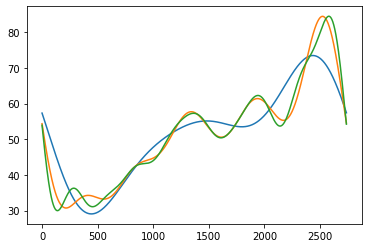

In [73]:
for num_ in [3, 6, 9]:
    fft_list_m10= np.copy(fft_list); fft_list_m10[num_:-num_]=0
    plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))

In [69]:
fft_list_3 = np.copy(fft_list); fft_list_3[3:-3]=0
dataset_total['FT3'] = np.fft.ifft(fft_list_3).real

In [70]:
fft_list_6 = np.copy(fft_list); fft_list_6[6:-6]=0
dataset_total['FT6'] = np.fft.ifft(fft_list_6).real

In [71]:
fft_list_9 = np.copy(fft_list); fft_list_9[9:-9]=0
dataset_total['FT9'] = np.fft.ifft(fft_list_9).real

In [72]:
dataset_total

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,MACD,20sd,upper_band,lower_band,ema,momentum,log_momentum,FT3,FT6,FT9
0,2009-07-27,29.694656,29.751907,29.026718,29.360687,18.955816,21026758,NaN,NaN,29.360687,...,0.000000,NaN,NaN,NaN,29.360687,28.360687,3.345004,57.350007,54.380491,53.938574
1,2009-07-28,29.303434,29.494274,28.406488,28.645039,18.493778,23627265,NaN,NaN,28.989101,...,-0.016056,NaN,NaN,NaN,28.823951,27.645039,3.319446,57.256231,54.174474,53.631444
2,2009-07-29,28.635496,28.759542,28.158398,28.501907,18.401367,16696736,NaN,NaN,28.814057,...,-0.024897,NaN,NaN,NaN,28.600997,27.501907,3.314255,57.162340,53.968789,53.324847
3,2009-07-30,28.826336,29.551527,28.511450,28.568703,18.444492,24300290,NaN,NaN,28.745466,...,-0.025897,NaN,NaN,NaN,28.579199,27.568703,3.316681,57.068337,53.763447,53.018827
4,2009-07-31,28.816793,29.179390,28.540075,28.635496,18.487621,16269362,NaN,NaN,28.719964,...,-0.023237,NaN,NaN,NaN,28.616885,27.635496,3.319101,56.974224,53.558463,52.713429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.547707,78.396950,77.137405,77.814888,73.378548,9292930,76.515814,74.863687,75.491099,...,0.555842,1.816324,78.496336,71.231038,77.807402,76.814888,4.341398,57.817099,55.415062,55.480641
2734,2020-06-05,78.349236,79.322517,77.757637,78.492363,74.017395,10413347,77.157852,75.097238,75.713415,...,0.709745,1.857931,78.813100,71.381377,78.264043,77.492363,4.350179,57.723926,55.207594,55.171523
2735,2020-06-08,77.433205,79.389313,77.433205,79.103050,74.593254,9956838,77.684024,75.428935,75.964499,...,0.870952,1.960788,79.350511,71.507360,78.823381,78.103050,4.358029,57.630627,55.000389,54.862711
2736,2020-06-09,79.379768,79.685112,78.358780,78.492363,74.017395,8846168,77.893947,75.695202,76.151748,...,0.938612,2.043482,79.782166,71.608238,78.602702,77.492363,4.350179,57.537207,54.793461,54.554253


## ARIMA 

We put the true data for the training values, and the predictions for the test values.

In [84]:
training_predictions = np.concatenate((train, np.array(predictions)))

In [85]:
dataset_total['ARIMA'] = training_predictions

In [86]:
dataset_total

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,20sd,upper_band,lower_band,ema,momentum,log_momentum,FT3,FT6,FT9,ARIMA
0,2009-07-27,29.694656,29.751907,29.026718,29.360687,18.955816,21026758,NaN,NaN,29.360687,...,NaN,NaN,NaN,29.360687,28.360687,3.345004,57.350007,54.380491,53.938574,29.360687
1,2009-07-28,29.303434,29.494274,28.406488,28.645039,18.493778,23627265,NaN,NaN,28.989101,...,NaN,NaN,NaN,28.823951,27.645039,3.319446,57.256231,54.174474,53.631444,28.645039
2,2009-07-29,28.635496,28.759542,28.158398,28.501907,18.401367,16696736,NaN,NaN,28.814057,...,NaN,NaN,NaN,28.600997,27.501907,3.314255,57.162340,53.968789,53.324847,28.501907
3,2009-07-30,28.826336,29.551527,28.511450,28.568703,18.444492,24300290,NaN,NaN,28.745466,...,NaN,NaN,NaN,28.579199,27.568703,3.316681,57.068337,53.763447,53.018827,28.568703
4,2009-07-31,28.816793,29.179390,28.540075,28.635496,18.487621,16269362,NaN,NaN,28.719964,...,NaN,NaN,NaN,28.616885,27.635496,3.319101,56.974224,53.558463,52.713429,28.635496
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.547707,78.396950,77.137405,77.814888,73.378548,9292930,76.515814,74.863687,75.491099,...,1.816324,78.496336,71.231038,77.807402,76.814888,4.341398,57.817099,55.415062,55.480641,78.191500
2734,2020-06-05,78.349236,79.322517,77.757637,78.492363,74.017395,10413347,77.157852,75.097238,75.713415,...,1.857931,78.813100,71.381377,78.264043,77.492363,4.350179,57.723926,55.207594,55.171523,77.972240
2735,2020-06-08,77.433205,79.389313,77.433205,79.103050,74.593254,9956838,77.684024,75.428935,75.964499,...,1.960788,79.350511,71.507360,78.823381,78.103050,4.358029,57.630627,55.000389,54.862711,78.309688
2736,2020-06-09,79.379768,79.685112,78.358780,78.492363,74.017395,8846168,77.893947,75.695202,76.151748,...,2.043482,79.782166,71.608238,78.602702,77.492363,4.350179,57.537207,54.793461,54.554253,79.039159


## Correlated Assets

We put in the closing data for the correlated assets.

In [87]:
dataset_total['SNP'] = list(SNP_data['Close'])
dataset_total['PFE'] = list(PFE_data['Close'])
dataset_total['JNJ'] = list(JNJ_data['Close'])
dataset_total['BMY'] = list(BMY_data['Close'])
dataset_total['VTRS'] = list(VTRS_data['Close'])
dataset_total['AMGN'] = list(AMGN_data['Close'])
dataset_total['VZ'] = list(VZ_data['Close'])
dataset_total['SNY'] = list(SNY_data['Close'])
dataset_total['GSK'] = list(GSK_data['Close'])
dataset_total['LLY'] = list(LLY_data['Close'])
dataset_total['NVS'] = list(NVS_data['Close'])
dataset_total['NYSE'] = list(NYSE_data['Close'])
dataset_total['NASDAQ'] = list(NASDAQ_data['Close'])

In [88]:
dataset_total

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,BMY,VTRS,AMGN,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ
0,2009-07-27,29.694656,29.751907,29.026718,29.360687,18.955816,21026758,NaN,NaN,29.360687,...,14.105061,11.824374,46.592819,16.079933,20.185129,19.793089,23.153368,25.531801,6364.660156,1967.890015
1,2009-07-28,29.303434,29.494274,28.406488,28.645039,18.493778,23627265,NaN,NaN,28.989101,...,13.973110,12.273897,47.857883,16.287413,20.535158,19.813576,23.100670,25.589666,6328.669922,1975.510010
2,2009-07-29,28.635496,28.759542,28.158398,28.501907,18.401367,16696736,NaN,NaN,28.814057,...,14.243599,12.615924,48.478912,16.588266,20.258821,19.897013,22.988689,25.248241,6280.569824,1967.760010
3,2009-07-30,28.826336,29.551527,28.511450,28.568703,18.444492,24300290,NaN,NaN,28.745466,...,14.223808,12.830913,48.386909,16.759441,20.172846,19.917746,23.087490,25.815357,6384.310059,1984.300049
4,2009-07-31,28.816793,29.179390,28.540075,28.635496,18.487621,16269362,NaN,NaN,28.719964,...,14.342560,12.889544,47.773556,16.634949,20.043888,19.845194,22.982105,26.399832,6424.279785,1978.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.547707,78.396950,77.137405,77.814888,73.378548,9292930,76.515814,74.863687,75.491099,...,57.630974,17.296814,209.593124,52.923214,48.132076,38.423382,146.373550,81.836136,12286.980469,9615.809570
2734,2020-06-05,78.349236,79.322517,77.757637,78.492363,74.017395,10413347,77.157852,75.097238,75.713415,...,58.047424,17.267496,214.138351,53.404163,48.276615,38.469505,144.916718,82.576424,12641.440430,9814.080078
2735,2020-06-08,77.433205,79.389313,77.433205,79.103050,74.593254,9956838,77.684024,75.428935,75.964499,...,58.142071,18.352213,214.214249,53.727886,48.960777,39.087601,144.916718,82.364914,12836.599609,9924.750000
2736,2020-06-09,79.379768,79.685112,78.358780,78.492363,74.017395,8846168,77.893947,75.695202,76.151748,...,57.668831,18.029728,213.407700,53.515152,48.999317,38.635563,144.839020,85.018433,12619.519531,9953.750000


## Sentiment Analysis

We put in the values of the sentiment analysis according to the date. We also note that not some days do not have news related to stock, so we assume that the sentimental analysis is fully neutral for those days.

In [94]:
positive_l = []
negative_l = []
neutral_l = []
for i in dataset_total['Date']:
    counter = 0
    pos = 0
    neg = 0
    neu = 0
    for j in MRK_headlines.index:
        k = MRK_headlines['date'][j]
        x = helper.date_parser(k[:10]).date()
        if (x == i):
            pos = pos + MRK_headlines['positive'][MRK_headlines.index == j].item()
            neg = neg + MRK_headlines['negative'][MRK_headlines.index == j].item()
            neu = neu + MRK_headlines['neutral'][MRK_headlines.index == j].item()
            counter += 1
    if (counter == 0):
        positive_l.append(0)
        negative_l.append(0)
        neutral_l.append(1)
    else:
        positive_l.append(pos/counter)
        negative_l.append(neg/counter)
        neutral_l.append(neu/counter)

In [95]:
dataset_total["pos"] = positive_l
dataset_total["neg"] = negative_l
dataset_total["neu"] = neutral_l

In [96]:
dataset_total

,Date,Open,High,Low,Close,Adj Close,Volume,ma7,ma21,26ema,...,VZ,SNY,GSK,LLY,NVS,NYSE,NASDAQ,pos,neg,neu
0,2009-07-27,29.694656,29.751907,29.026718,29.360687,18.955816,21026758,NaN,NaN,29.360687,...,16.079933,20.185129,19.793089,23.153368,25.531801,6364.660156,1967.890015,0.032246,0.042140,0.925613
1,2009-07-28,29.303434,29.494274,28.406488,28.645039,18.493778,23627265,NaN,NaN,28.989101,...,16.287413,20.535158,19.813576,23.100670,25.589666,6328.669922,1975.510010,0.000000,0.000000,1.000000
2,2009-07-29,28.635496,28.759542,28.158398,28.501907,18.401367,16696736,NaN,NaN,28.814057,...,16.588266,20.258821,19.897013,22.988689,25.248241,6280.569824,1967.760010,0.000000,0.000000,1.000000
3,2009-07-30,28.826336,29.551527,28.511450,28.568703,18.444492,24300290,NaN,NaN,28.745466,...,16.759441,20.172846,19.917746,23.087490,25.815357,6384.310059,1984.300049,0.000000,0.000000,1.000000
4,2009-07-31,28.816793,29.179390,28.540075,28.635496,18.487621,16269362,NaN,NaN,28.719964,...,16.634949,20.043888,19.845194,22.982105,26.399832,6424.279785,1978.500000,0.000000,0.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.547707,78.396950,77.137405,77.814888,73.378548,9292930,76.515814,74.863687,75.491099,...,52.923214,48.132076,38.423382,146.373550,81.836136,12286.980469,9615.809570,0.491229,0.013877,0.494893
2734,2020-06-05,78.349236,79.322517,77.757637,78.492363,74.017395,10413347,77.157852,75.097238,75.713415,...,53.404163,48.276615,38.469505,144.916718,82.576424,12641.440430,9814.080078,0.825178,0.013980,0.160842
2735,2020-06-08,77.433205,79.389313,77.433205,79.103050,74.593254,9956838,77.684024,75.428935,75.964499,...,53.727886,48.960777,39.087601,144.916718,82.364914,12836.599609,9924.750000,0.000000,0.000000,1.000000
2736,2020-06-09,79.379768,79.685112,78.358780,78.492363,74.017395,8846168,77.893947,75.695202,76.151748,...,53.515152,48.999317,38.635563,144.839020,85.018433,12619.519531,9953.750000,0.543354,0.013090,0.443555


## Pruning the data 

Now, we remove all the useless columns and rows. We remove any other MRK data other than the closing price, and we shift the values of the closing prices up by 1 (since that's the value we want to predict, the next day's data). Furthermore, we remove any row with null values, which is only the days that do not have the moving averages (for obvious reasons), and the day we shifted up from.

In [97]:
dataset_total.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ma7',
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'momentum', 'log_momentum', 'FT3', 'FT6', 'FT9', 'ARIMA', 'SNP',
       'PFE', 'JNJ', 'BMY', 'VTRS', 'AMGN', 'VZ', 'SNY', 'GSK', 'LLY', 'NVS',
       'NYSE', 'NASDAQ', 'pos', 'neg', 'neu'],
      dtype='object')

In [98]:
dataset_total_df = dataset_total[['Date','Close', 'Volume', 'ma7',
       'ma21', '26ema', '12ema', 'MACD', '20sd', 'upper_band', 'lower_band',
       'ema', 'momentum', 'log_momentum', 'pos', 'neg', 'neu', 'SNP', 'PFE',
       'JNJ', 'BMY', 'VTRS', 'AMGN', 'VZ', 'SNY', 'GSK', 'LLY', 'NVS', 'NYSE',
       'NASDAQ', 'FT3', 'FT6', 'FT9', 'ARIMA']]

In [99]:
is_NaN = dataset_total_df.isnull()
row_has_NaN = is_NaN.any(axis=1)
dataset_total_df_clean = dataset_total_df[-row_has_NaN]

In [100]:
dataset_total_df_clean

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,SNY,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA
20,2009-08-24,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,...,20.842205,20.441219,22.546120,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327,31.011450
21,2009-08-25,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,...,20.854485,20.290920,22.639698,26.532934,6697.220215,2024.229980,55.359252,50.140845,47.659130,31.440840
22,2009-08-26,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,...,20.866766,20.280550,22.492653,26.608170,6687.939941,2024.430054,55.263482,49.944470,47.372320,31.183207
23,2009-08-27,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,...,21.014149,20.513784,22.800129,26.984316,6722.310059,2027.729980,55.167638,49.748691,47.086936,31.364504
24,2009-08-28,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,...,21.204519,20.285738,22.459227,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017,30.839695
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2733,2020-06-04,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,...,48.132076,38.423382,146.373550,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641,78.191500
2734,2020-06-05,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,...,48.276615,38.469505,144.916718,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523,77.972240
2735,2020-06-08,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,...,48.960777,39.087601,144.916718,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711,78.309688
2736,2020-06-09,78.492363,8846168,77.893947,75.695202,76.151748,77.090360,0.938612,2.043482,79.782166,...,48.999317,38.635563,144.839020,85.018433,12619.519531,9953.750000,57.537207,54.793461,54.554253,79.039159


In [101]:
target_sensor = "Close"
features = list(dataset_total_df_clean.columns.difference([target_sensor]))

forecast_lead = 1
target = f"{target_sensor}_lead{forecast_lead}"

dataset_total_df_clean[target] = dataset_total_df_clean[target_sensor].shift(-forecast_lead)
dataset_total_df_clean = dataset_total_df_clean.iloc[:-forecast_lead]

<b> This is the final dataset that we use, and the features it contains. </b>

In [102]:
dataset_total_df_clean

,Date,Close,Volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,...,GSK,LLY,NVS,NYSE,NASDAQ,FT3,FT6,FT9,ARIMA,Close_lead1
20,2009-08-24,31.011450,14227229,30.050436,29.200291,29.514006,29.867322,0.353316,0.835852,30.871996,...,20.441219,22.546120,26.214659,6671.140137,2017.979980,55.454947,50.337802,47.947327,31.011450,31.440840
21,2009-08-25,31.440840,20081566,30.318975,29.299346,29.688906,30.115697,0.426791,0.963549,31.226444,...,20.290920,22.639698,26.532934,6697.220215,2024.229980,55.359252,50.140845,47.659130,31.440840,31.183207
22,2009-08-26,31.183207,10438080,30.564340,29.420211,29.822316,30.283528,0.461212,1.026446,31.473102,...,20.280550,22.492653,26.608170,6687.939941,2024.430054,55.263482,49.944470,47.372320,31.183207,31.364504
23,2009-08-27,31.364504,10302154,30.858779,29.556525,29.957940,30.452906,0.494965,1.086420,31.729366,...,20.513784,22.800129,26.984316,6722.310059,2027.729980,55.167638,49.748691,47.086936,31.364504,30.839695
24,2009-08-28,30.839695,12640452,30.973283,29.664667,30.034423,30.513340,0.478916,1.094567,31.853801,...,20.285738,22.459227,26.857002,6709.040039,2028.770020,55.071723,49.553518,46.803017,30.839695,30.944656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2732,2020-06-03,78.301529,13675457,75.931026,74.702836,75.305196,75.725497,0.420300,1.705192,78.113220,...,38.856968,148.141144,82.393753,12302.190430,9682.910156,57.910147,55.622779,55.790021,76.887436,77.814888
2733,2020-06-04,77.814888,9292930,76.515814,74.863687,75.491099,76.046941,0.555842,1.816324,78.496336,...,38.423382,146.373550,81.836136,12286.980469,9615.809570,57.817099,55.415062,55.480641,78.191500,78.492363
2734,2020-06-05,78.492363,10413347,77.157852,75.097238,75.713415,76.423160,0.709745,1.857931,78.813100,...,38.469505,144.916718,82.576424,12641.440430,9814.080078,57.723926,55.207594,55.171523,77.972240,79.103050
2735,2020-06-08,79.103050,9956838,77.684024,75.428935,75.964499,76.835451,0.870952,1.960788,79.350511,...,39.087601,144.916718,82.364914,12836.599609,9924.750000,57.630627,55.000389,54.862711,78.309688,78.492363


In [103]:
features = list(dataset_total_df_clean.columns.difference([target_sensor, 'Close_lead1', 'Date']))
features

['12ema',
 '20sd',
 '26ema',
 'AMGN',
 'ARIMA',
 'BMY',
 'FT3',
 'FT6',
 'FT9',
 'GSK',
 'JNJ',
 'LLY',
 'MACD',
 'NASDAQ',
 'NVS',
 'NYSE',
 'PFE',
 'SNP',
 'SNY',
 'VTRS',
 'VZ',
 'Volume',
 'ema',
 'log_momentum',
 'lower_band',
 'ma21',
 'ma7',
 'momentum',
 'neg',
 'neu',
 'pos',
 'upper_band']

In [104]:
dataset_total_df_clean.to_csv('dataset_MRK_prediction.csv')